In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision.models import vgg19
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import warnings
random.seed(42)
warnings.filterwarnings("ignore")

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [4]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
cuda = torch.cuda.is_available()
hr_height = 256

In [5]:
cuda

True

In [6]:
import cv2
import numpy as np

# Function to apply Reinhard tone mapping
def apply_tone_mapping(image):
    # Check if image is in HDR format (float32 or HDR image format)
    if image.dtype == np.float32:  # HDR images typically use float32
        # Create a Reinhard tone mapper with default parameters
        tonemap = cv2.createTonemapReinhard(gamma=1.0, intensity=0.0, light_adapt=0.0, color_adapt=0.0)

        # Apply the tone mapping algorithm
        ldr_image = tonemap.process(image)

        # Scale the output to 8-bit format (0-255)
        ldr_image = np.clip(ldr_image * 255, 0, 255).astype('uint8')
    else:
        # If it's not an HDR image, return it as-is
        ldr_image = image

    return ldr_image

# Function to correct skew in the image
def correct_skew(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use thresholding to create a binary image
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the minimum area rotated rectangle around the largest contour
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]

    # Correct the angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Get the image center and rotate to correct the skew
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation
    corrected_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return corrected_image

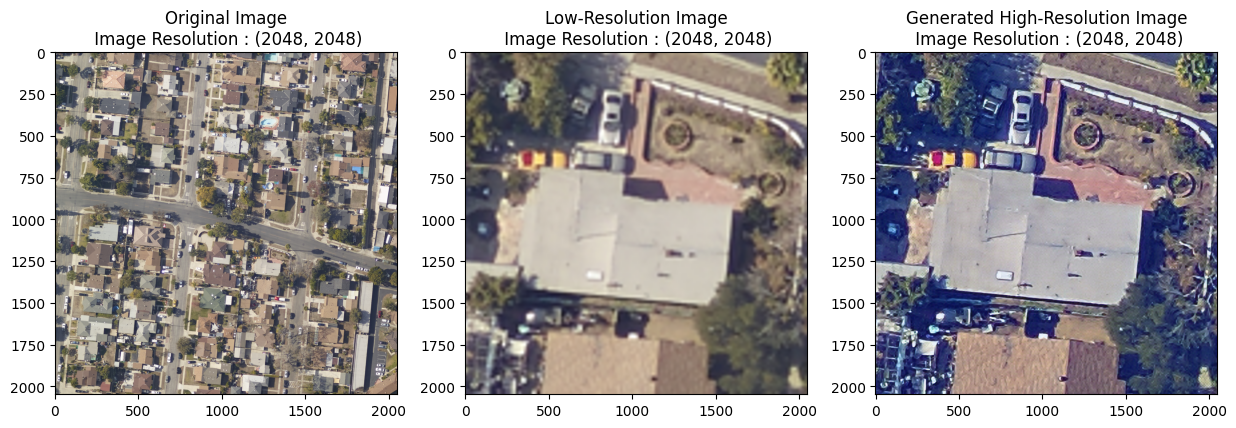

In [7]:
# Load Model Check Point and pridict the image

generator = GeneratorResNet()
generator.load_state_dict(torch.load("/content/generator.pth"))
generator.eval()

# Prepare the single image for testing
# image_path = "test_images/test_image.jpg"  # Replace with the path to your image
image_path = "/content/test_image.jpg"  # Replace with the path to your image
original_image = Image.open(image_path)
original_image = correct_skew(np.array(original_image))
original_image = apply_tone_mapping(original_image)
original_image = Image.fromarray(original_image)
width, height = original_image.size   # Get dimensions
new_width,new_height,offset = 256,256,256*2
left = (width - new_width + offset)/2
top = (height - new_height + offset)/2
right = (width + new_width + offset)/2
bottom = (height + new_height + offset)/2

# Crop the center of the image
image = original_image.crop((left, top, right, bottom))

transform = transforms.Compose([
    transforms.Resize((hr_height, hr_height), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_image = transform(image).unsqueeze(0)
if cuda:
    input_image = input_image

# Generate high-resolution output
with torch.no_grad():
    output_image = generator(input_image)
# Convert the generated output to a NumPy array and transpose it
output_image = output_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
output_image = (output_image + 1) / 2.0  # Unnormalize the image
output_image = Image.fromarray((output_image * 255).astype(np.uint8))
transform = transforms.Compose([
    transforms.Resize((hr_height//2, hr_height//2), Image.BICUBIC),
])
image = transform(image)
transform = transforms.Compose([
    transforms.Resize((height, height), Image.BICUBIC),
])
image = transform(image)
output_image = transform(output_image)
# image.show()
# Display the original low-resolution image and the generated high-resolution image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\n Image Resolution : {original_image.size}")
axes[1].imshow(image)
axes[1].set_title(f"Low-Resolution Image\n Image Resolution : {image.size}")
axes[2].imshow(output_image)
axes[2].set_title(f"Generated High-Resolution Image\n Image Resolution : {output_image.size}")
plt.show()

original_image.show(title="Original Image")
image.show(title="Low-Resolution Image")
output_image.show(title="Generated High-Resolution Image")

# output_image.save("output_images/high_res_generated.png")
# image.save("output_images/low_res_input.png")

PSNR: 10.550707740030118
SSIM: 0.10927411494549807
FID: 0.0163809400666972
GAM: 0.409202375486751


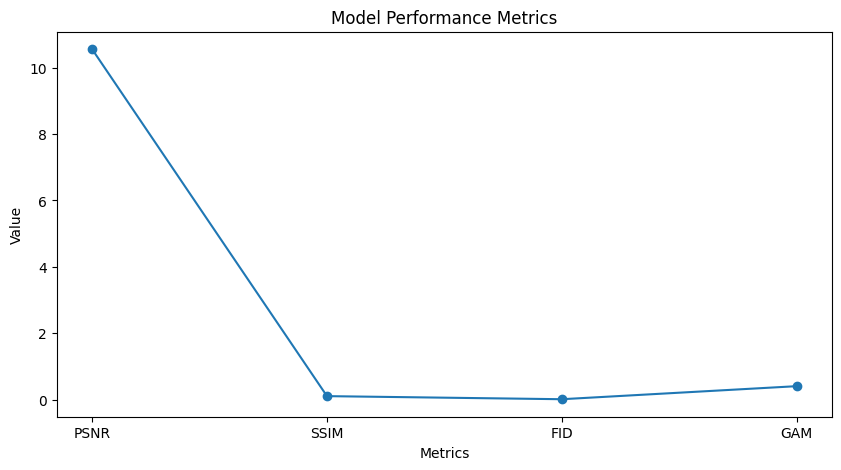

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
from PIL import Image

# PSNR Function
def compute_psnr(original_image, output_image):
    return psnr(original_image, output_image, data_range=1)

# SSIM Function
def compute_ssim(original_image, output_image):
    return ssim(original_image, output_image, multichannel=True, data_range=1, win_size=3)  # Set win_size to 3

# FID Function
def compute_fid(original_image, output_image):
    # Reshape the images if necessary to ensure they are vectors
    original_image = original_image.reshape(-1, original_image.shape[-1])
    output_image = output_image.reshape(-1, output_image.shape[-1])

    # Calculate the mean and covariance of the original_image and output_image images
    mu1, sigma1 = np.mean(original_image, axis=0), np.cov(original_image, rowvar=False)
    mu2, sigma2 = np.mean(output_image, axis=0), np.cov(output_image, rowvar=False)

    # Check that the covariance matrices are square
    if sigma1.shape != sigma2.shape or sigma1.shape[0] != sigma1.shape[1]:
        raise ValueError("Covariance matrices must be square and of the same size")

    # Calculate the Frechet distance (FID)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Numerical issues
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_gam(psnr_value, ssim_value, max_psnr):
    # Normalize PSNR and SSIM
    normalized_psnr = psnr_value / max_psnr
    normalized_ssim = (ssim_value + 1) / 2  # Normalize SSIM to [0, 1]

    # Calculate GAM with equal weights
    gam_value = 0.5 * normalized_psnr + 0.5 * normalized_ssim
    return gam_value

max_psnr = 40

# Convert images to NumPy arrays
original_image = np.array(original_image)  # Assuming original_image is a PIL Image
output_image = np.array(output_image)      # Assuming output_image is also a PIL Image

# Normalize images to range [0, 1]
original_image = original_image / 255.0
output_image = output_image / 255.0

# Compute the metrics
psnr_value = compute_psnr(original_image, output_image)
ssim_value = compute_ssim(original_image, output_image)
fid_value = compute_fid(original_image, output_image)
gam_value = calculate_gam(psnr_value, ssim_value, max_psnr)

# Display the metrics
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")
print(f"FID: {fid_value}")
print(f"GAM: {gam_value}")

# Plot the results as a line graph
metrics = {'PSNR': psnr_value, 'SSIM': ssim_value, 'FID': fid_value, 'GAM':gam_value}
plt.figure(figsize=(10, 5))
plt.plot(metrics.keys(), metrics.values(), marker='o')
plt.title("Model Performance Metrics")
plt.ylabel("Value")
plt.xlabel("Metrics")
plt.show()


In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy
from skimage.transform import resize

# Load the InceptionV3 model for feature extraction
inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Inception Score calculation function
def calculate_inception_score(images, n_splits=10):
    images_resized = np.array([resize(image, (299, 299), anti_aliasing=True) for image in images])

    # Normalize the image range to [0, 1] if necessary
    images_resized = images_resized / 255.0

    images_resized = preprocess_input(images_resized)

    preds = inception_model.predict(images_resized)

    scores = []
    for i in range(n_splits):
        part = preds[i * len(preds) // n_splits: (i + 1) * len(preds) // n_splits]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(p, py) for p in part])))

    inception_score_mean = np.mean(scores)
    inception_score_std = np.std(scores)
    return inception_score_mean, inception_score_std

# Dummy prediction creation (replace this with your actual image data)
# Example: Create a random array simulating generated images
# Assuming you want 5 generated images, each with size (height=128, width=128, channels=3)
num_images = 5
image_height = 128
image_width = 128
channels = 3

# Replace this with your actual generated images
# Here we're creating random images for demonstration
predictions = np.random.rand(num_images, image_height, image_width, channels).astype(np.float32)

# Calculate Inception Scores for all predictions
inception_scores = []
for pred in predictions:
    # Expand dims to create a batch of one image
    mean, std = calculate_inception_score(np.expand_dims(pred, axis=0))

    # Check if mean and std are finite
    if np.isfinite(mean) and np.isfinite(std):
        inception_scores.append((mean, std))

# Unzip the scores into separate lists
if inception_scores:
    means, stds = zip(*inception_scores)
else:
    means, stds = [], []

# Plot the Inception Score with error bars if there are valid scores
if means:  # Ensure we have means to plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(means)), means, yerr=stds, capsize=5, color='skyblue')
    plt.xticks(range(len(means)), [f'Image {i + 1}' for i in range(len(means))])
    plt.title("Inception Score with Standard Deviation")
    plt.ylabel("Inception Score")
    plt.xlabel("Generated Images")
    plt.ylim(0, np.max(means) + 1)  # Adjust y-limit for better visibility
    plt.show()
else:
    print("No valid Inception Scores to plot.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
No valid Inception Scores to plot.
